In [1]:
#import the libraries
import math
import pandas_datareader as web
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
from keras.models import load_model
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import pickle
import pandas as pd
import time

start_time = time.time()


In [2]:
#MACRO DEF

STOCK = 'NECCLTD.BO'
EPOCHS = 100
open_model_path = "machine learning model/"+STOCK+"_open_model.h5"
high_model_path = "machine learning model/"+STOCK+"_high_model.h5"
low_model_path = "machine learning model/"+STOCK+"_low_model.h5"
close_model_path = "machine learning model/"+STOCK+"_close_model.h5"
volume_model_path = "machine learning model/"+STOCK+"_volume_model.h5"
error_model_path = "machine learning model/"+STOCK+"_error_model.h5"
error_data = "machine learning model/"+STOCK+"_error_data.csv"
START_DATE = '2012-01-01'
END_DATE = '2022-03-11'
PREDICT_DATE = '2022-03-11'
ERR_EPOCHS = 120

In [3]:
#get the stock data
df = web.DataReader(STOCK, data_source='yahoo' , start=START_DATE , end=END_DATE)

#show the data
df


,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2012-08-10,14.500000,13.812500,13.812500,14.500000,17484.0,14.500000
2012-08-13,15.225000,15.225000,15.225000,15.225000,17148.0,15.225000
2012-08-14,15.975000,15.975000,15.975000,15.975000,8088.0,15.975000
2012-08-16,16.762501,16.762501,16.762501,16.762501,31348.0,16.762501
2012-08-17,17.600000,17.600000,17.600000,17.600000,29488.0,17.600000
...,...,...,...,...,...,...
2022-03-07,19.400000,18.350000,19.400000,18.900000,11649.0,18.900000
2022-03-08,19.500000,18.650000,18.650000,18.799999,5650.0,18.799999
2022-03-09,19.450001,18.700001,19.049999,19.200001,10121.0,19.200001


In [4]:
#get the number of rows and column in the data set
df.shape

(2360, 6)

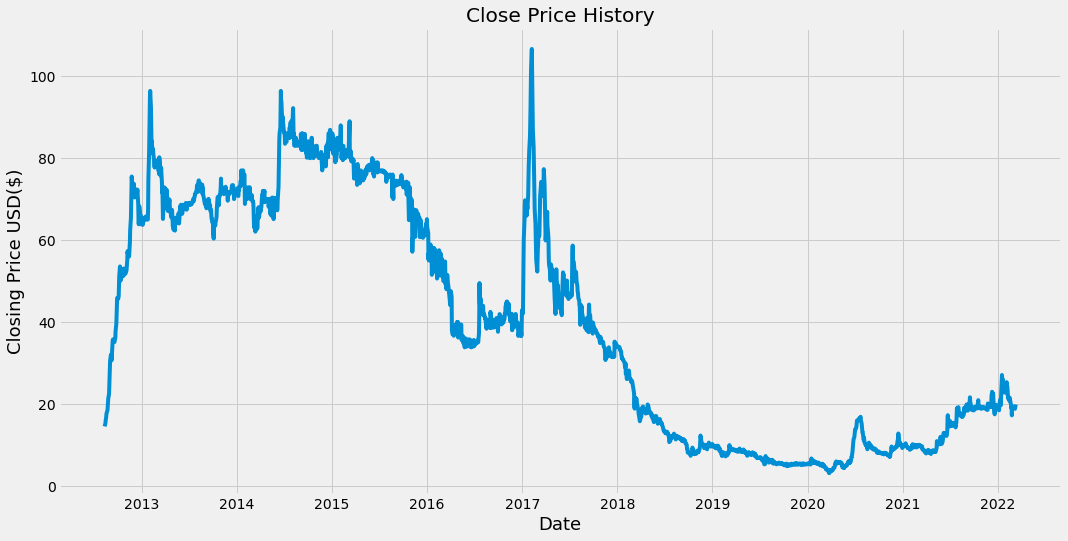

In [5]:
#Visualing the closing price history
plt.figure(figsize=(16,8))
plt.title('Close Price History')
plt.plot(df['Close'])
plt.xlabel('Date', fontsize=18)
plt.ylabel('Closing Price USD($)', fontsize=18)
plt.show()

In [6]:
#Create a new data
data = df.filter(['Close'])
#convert the dataframe to a numpy array
dataset = data.values
#get the number of rows to train the model on
training_data_len = math.ceil(len(dataset)*.8)
training_data_len

1888

In [7]:
#Scale the data
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(dataset)

scaled_data

array([[0.11009174],
       [0.11709319],
       [0.12433607],
       ...,
       [0.15548045],
       [0.16079189],
       [0.16175761]])

In [8]:
#creating the training data set
#create the scaled training data set
train_data = scaled_data[0:training_data_len,:]
#split the data into x_train and y_train data sets
x_train = []
y_train = []
for i in range(60, len(train_data)):
    x_train.append(train_data[i-60:i,0])
    y_train.append(train_data[i,0])
    if i<=61:
        print(x_train)
        print(y_train)
        print()

[array([0.11009174, 0.11709319, 0.12433607, 0.1319411 , 0.14002897,
       0.148479  , 0.15729117, 0.16658619, 0.17636407, 0.18662481,
       0.20823274, 0.22561564, 0.25108643, 0.26424432, 0.2788508 ,
       0.27933367, 0.26545147, 0.26617576, 0.28090294, 0.31265087,
       0.31530661, 0.31156445, 0.31047803, 0.30975373, 0.30902944,
       0.3167552 , 0.31711733, 0.33437951, 0.3524867 , 0.37155964,
       0.39159827, 0.41260261, 0.41224044, 0.41091261, 0.41682762,
       0.43915983, 0.46257846, 0.48720424, 0.47006278, 0.45352486,
       0.47766779, 0.46100918, 0.46982134, 0.46837275, 0.46499275,
       0.4809271 , 0.46390633, 0.46595845, 0.48225493, 0.48177208,
       0.47006278, 0.47464992, 0.47778851, 0.47790923, 0.47706421,
       0.50241429, 0.52269433, 0.51690004, 0.52366007, 0.51738289])]
[0.5107435876811859]

[array([0.11009174, 0.11709319, 0.12433607, 0.1319411 , 0.14002897,
       0.148479  , 0.15729117, 0.16658619, 0.17636407, 0.18662481,
       0.20823274, 0.22561564, 0.251

In [9]:
#Convert the X_train and Y_train to numpy arrays
x_train , y_train = np.array(x_train), np.array(y_train)

In [10]:
#Reshape the data
x_train = np.reshape(x_train,(x_train.shape[0],x_train.shape[1],1))
x_train.shape

(1828, 60, 1)

In [11]:
#Building the LSTM model
close_model = Sequential()
close_model.add(LSTM(50, return_sequences=True, input_shape =(x_train.shape[1],1)))
close_model.add(LSTM(50, return_sequences=True))
close_model.add(LSTM(50, return_sequences=True))
close_model.add(LSTM(50, return_sequences=False))
close_model.add(Dense(25))
close_model.add(Dense(1))

In [12]:
#compile the Model
close_model.compile(optimizer='adam', loss='mean_squared_error')


In [13]:
#train the model
close_model.fit(x_train, y_train, batch_size=32, epochs=EPOCHS)

Epoch 1/100
58/58 [==============================] - 13s 124ms/step - loss: 0.0186
Epoch 2/100
58/58 [==============================] - 9s 156ms/step - loss: 0.0032
Epoch 3/100
58/58 [==============================] - 9s 156ms/step - loss: 0.0029
Epoch 4/100
58/58 [==============================] - 9s 154ms/step - loss: 0.0034
Epoch 5/100
58/58 [==============================] - 9s 155ms/step - loss: 0.0027
Epoch 6/100
58/58 [==============================] - 9s 158ms/step - loss: 0.0023
Epoch 7/100
58/58 [==============================] - 9s 157ms/step - loss: 0.0021
Epoch 8/100
58/58 [==============================] - 9s 157ms/step - loss: 0.0016
Epoch 9/100
58/58 [==============================] - 9s 156ms/step - loss: 0.0015
Epoch 10/100
58/58 [==============================] - 9s 155ms/step - loss: 0.0013
Epoch 11/100
58/58 [==============================] - 9s 156ms/step - loss: 0.0010
Epoch 12/100
58/58 [==============================] - 9s 156ms/step - loss: 9.9391e-04
Epoch 13

58/58 [==============================] - 9s 156ms/step - loss: 2.7660e-04
Epoch 96/100
58/58 [==============================] - 9s 156ms/step - loss: 3.4494e-04
Epoch 97/100
58/58 [==============================] - 9s 157ms/step - loss: 3.1362e-04
Epoch 98/100
58/58 [==============================] - 9s 157ms/step - loss: 3.2629e-04
Epoch 99/100
58/58 [==============================] - 9s 157ms/step - loss: 2.7704e-04
Epoch 100/100
58/58 [==============================] - 9s 158ms/step - loss: 2.6346e-04


In [14]:
#create the testing data set
#create a new array containing scaled values from index 1543 to 2003
test_data = scaled_data[training_data_len - 60: , :]
#create the data sets x_test adn y_test
x_test = []
y_test = dataset[training_data_len:,:]
for i in range(60, len(test_data)):
    x_test.append(test_data[i-60:i,0])
    
    


In [15]:
#convert the data to a numpy array
x_test = np.array(x_test)

In [16]:
#resahpe the data
x_test = np.reshape(x_test,(x_test.shape[0],x_test.shape[1],1))

In [17]:
#get the models predicted price values
predictions = close_model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

In [18]:
#get the root mean squared error (RMSE)
rmse =  np.sqrt(np.mean(predictions - y_test)**2)
rmse

0.4632971983844951

C:\Users\Abhishek Rao\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.7_qbz5n2kfra8p0\LocalCache\local-packages\Python37\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


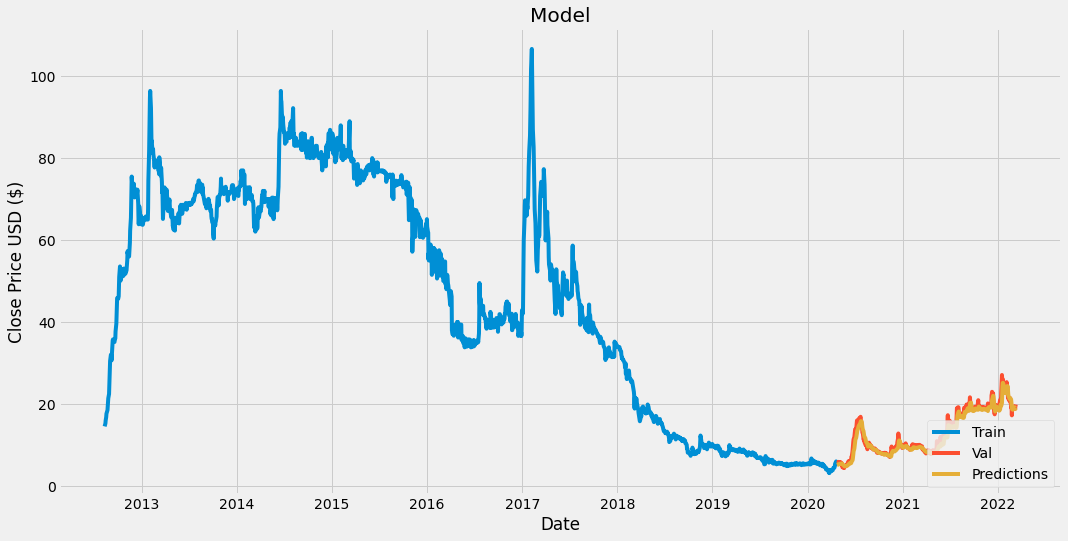

In [19]:
#plot the date
train = data[:training_data_len]
valid = data[training_data_len:]
valid['Predictions'] = predictions
#visualize the data
plt.figure(figsize=(16,8))
plt.title('Model')
plt.xlabel('Date')
plt.ylabel('Close Price USD ($)')
plt.plot(train['Close'])
plt.plot(valid[['Close', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()

In [20]:
#show the valid and predicted prices
valid

,Close,Predictions
Date,,
2020-04-23,5.500000,5.108882
2020-04-24,5.500000,5.128369
2020-04-27,5.700000,5.129386
2020-04-28,5.840000,5.153467
2020-04-29,5.700000,5.216429
...,...,...
2022-03-07,18.900000,19.176783
2022-03-08,18.799999,19.043694
2022-03-09,19.200001,18.839060


In [21]:
#get the Quote
stock_quote = web.DataReader(STOCK, data_source = 'yahoo', start=START_DATE, end=END_DATE)
#create new data frame
new_df = stock_quote.filter(['Close'])
#get the last 60 days closing price values and convert the dataframe to an array
last_60_days = new_df[-60:].values
#scale the data to be values between 0 and 1
last_60_days_scaled = scaler.fit_transform(last_60_days)
#create the empty list
x_test = []
#append the past 60 days
x_test.append(last_60_days_scaled)
#convert the x_test data set to a numpy array
x_test = np.array(x_test)
x_test = np.reshape(x_test,(x_test.shape[0],x_test.shape[1],1))
#get the predicted scaled price
close_pred_price = close_model.predict(x_test)
#undo the scaling
close_pred_price = scaler.inverse_transform(close_pred_price)
print(close_pred_price)


[[19.511204]]


In [22]:
stock_quote2 = web.DataReader(STOCK, data_source = 'yahoo', start=START_DATE, end=PREDICT_DATE)
print(stock_quote2['Close'])

Date
2012-08-10    14.500000
2012-08-13    15.225000
2012-08-14    15.975000
2012-08-16    16.762501
2012-08-17    17.600000
                ...    
2022-03-07    18.900000
2022-03-08    18.799999
2022-03-09    19.200001
2022-03-10    19.750000
2022-03-11    19.850000
Name: Close, Length: 2360, dtype: float64


In [23]:
close_model.save(close_model_path)
loaded_close_model = load_model(close_model_path)


In [24]:
stock_quote2 = web.DataReader(STOCK, data_source = 'yahoo', start=START_DATE, end=PREDICT_DATE)
print(stock_quote2['Close'])

Date
2012-08-10    14.500000
2012-08-13    15.225000
2012-08-14    15.975000
2012-08-16    16.762501
2012-08-17    17.600000
                ...    
2022-03-07    18.900000
2022-03-08    18.799999
2022-03-09    19.200001
2022-03-10    19.750000
2022-03-11    19.850000
Name: Close, Length: 2360, dtype: float64


In [25]:
import winsound
frequency = 2500  # Set Frequency To 2500 Hertz
duration = 1000  # Set Duration To 1000 ms == 1 second
winsound.Beep(frequency, duration)

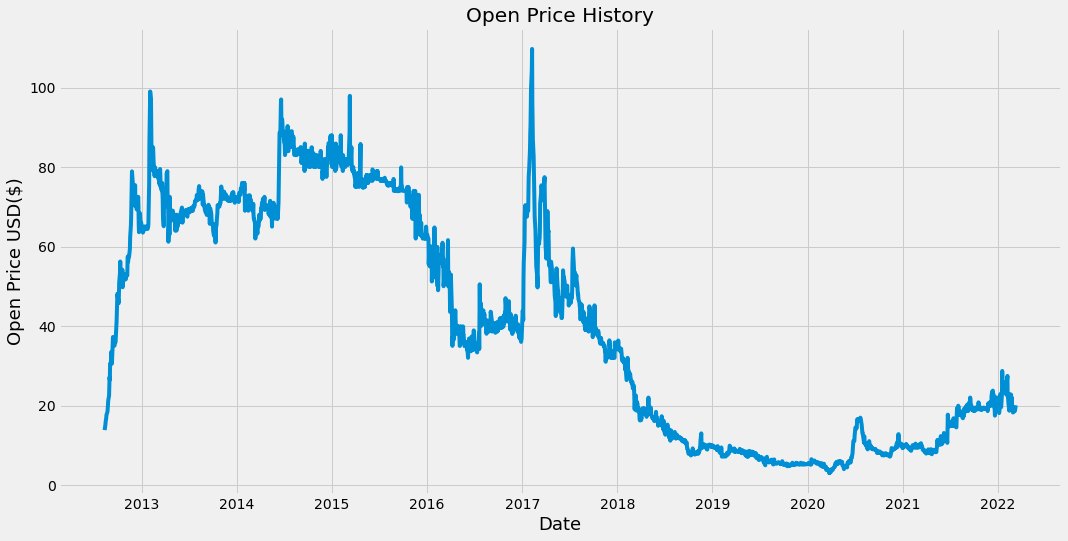

In [26]:
#Visualing the closing price history
plt.figure(figsize=(16,8))
plt.title('Open Price History')
plt.plot(df['Open'])
plt.xlabel('Date', fontsize=18)
plt.ylabel('Open Price USD($)', fontsize=18)
plt.show()

In [27]:
#Create a new data
data = df.filter(['Open'])
#convert the dataframe to a numpy array
dataset = data.values
#get the number of rows to train the model on
training_data_len = math.ceil(len(dataset)*.8)
training_data_len

1888

In [28]:
#Scale the data
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(dataset)

scaled_data

array([[0.10133552],
       [0.11457358],
       [0.12160263],
       ...,
       [0.15042174],
       [0.15557639],
       [0.15979381]])

In [29]:
#creating the training data set
#create the scaled training data set
train_data = scaled_data[0:training_data_len,:]
#split the data into x_train and y_train data sets
x_train = []
y_train = []
for i in range(60, len(train_data)):
    x_train.append(train_data[i-60:i,0])
    y_train.append(train_data[i,0])
    if i<=61:
        print(x_train)
        print(y_train)
        print()

[array([0.10133552, 0.11457358, 0.12160263, 0.12898314, 0.13683225,
       0.14503281, 0.15358483, 0.16260544, 0.17209466, 0.18205248,
       0.2030225 , 0.22610122, 0.22024368, 0.25820056, 0.25808342,
       0.28537958, 0.27202439, 0.25866918, 0.25796626, 0.30435801,
       0.32087629, 0.30459232, 0.30459232, 0.3001406 , 0.30049204,
       0.30459232, 0.30834117, 0.30880976, 0.3430178 , 0.35824742,
       0.38097472, 0.40135897, 0.42279757, 0.41002813, 0.40065606,
       0.42713217, 0.44985943, 0.4721181 , 0.49882849, 0.45688849,
       0.4451734 , 0.44540771, 0.45513122, 0.44283038, 0.47961575,
       0.43814434, 0.46391754, 0.45688849, 0.45454547, 0.46626056,
       0.46860357, 0.45688849, 0.46391754, 0.46391754, 0.46473761,
       0.4656748 , 0.49906281, 0.5107779 , 0.4978913 , 0.50374884])]
[0.5107778965208102]

[array([0.10133552, 0.11457358, 0.12160263, 0.12898314, 0.13683225,
       0.14503281, 0.15358483, 0.16260544, 0.17209466, 0.18205248,
       0.2030225 , 0.22610122, 0.220

In [30]:
#Convert the X_train and Y_train to numpy arrays
x_train , y_train = np.array(x_train), np.array(y_train)

In [31]:
#Reshape the data
x_train = np.reshape(x_train,(x_train.shape[0],x_train.shape[1],1))
x_train.shape

(1828, 60, 1)

In [32]:
#Building the LSTM model
open_model = Sequential()
open_model.add(LSTM(50, return_sequences=True, input_shape =(x_train.shape[1],1)))
open_model.add(LSTM(50, return_sequences=True))
open_model.add(LSTM(50, return_sequences=True))
open_model.add(LSTM(50, return_sequences=False))
open_model.add(Dense(25))
open_model.add(Dense(1))

In [33]:
#compile the Model
open_model.compile(optimizer='adam', loss='mean_squared_error')

In [34]:
#train the model
open_model.fit(x_train, y_train, batch_size=32, epochs=EPOCHS)

Epoch 1/100
58/58 [==============================] - 17s 154ms/step - loss: 0.0228
Epoch 2/100
58/58 [==============================] - 9s 152ms/step - loss: 0.0032
Epoch 3/100
58/58 [==============================] - 9s 151ms/step - loss: 0.0029
Epoch 4/100
58/58 [==============================] - 9s 152ms/step - loss: 0.0028
Epoch 5/100
58/58 [==============================] - 9s 152ms/step - loss: 0.0026
Epoch 6/100
58/58 [==============================] - 9s 151ms/step - loss: 0.0027
Epoch 7/100
58/58 [==============================] - 9s 151ms/step - loss: 0.0023
Epoch 8/100
58/58 [==============================] - 9s 151ms/step - loss: 0.0025
Epoch 9/100
58/58 [==============================] - 9s 153ms/step - loss: 0.0017
Epoch 10/100
58/58 [==============================] - 9s 151ms/step - loss: 0.0016
Epoch 11/100
58/58 [==============================] - 9s 153ms/step - loss: 0.0018
Epoch 12/100
58/58 [==============================] - 9s 153ms/step - loss: 0.0014
Epoch 13/100

58/58 [==============================] - 9s 152ms/step - loss: 4.8253e-04
Epoch 97/100
58/58 [==============================] - 9s 151ms/step - loss: 6.1111e-04
Epoch 98/100
58/58 [==============================] - 9s 151ms/step - loss: 4.2106e-04
Epoch 99/100
58/58 [==============================] - 9s 152ms/step - loss: 4.2434e-04
Epoch 100/100
58/58 [==============================] - 9s 152ms/step - loss: 5.3107e-04


In [35]:
#create the testing data set
#create a new array containing scaled values from index 1543 to 2003
test_data = scaled_data[training_data_len - 60: , :]
#create the data sets x_test adn y_test
x_test = []
y_test = dataset[training_data_len:,:]
for i in range(60, len(test_data)):
    x_test.append(test_data[i-60:i,0])
    
    


In [36]:
#convert the data to a numpy array
x_test = np.array(x_test)

In [37]:
#resahpe the data
x_test = np.reshape(x_test,(x_test.shape[0],x_test.shape[1],1))

In [38]:
#get the models predicted price values
predictions = open_model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

In [39]:
#get the root mean squared error (RMSE)
rmse =  np.sqrt(np.mean(predictions - y_test)**2)
rmse

0.2779305193383815

C:\Users\Abhishek Rao\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.7_qbz5n2kfra8p0\LocalCache\local-packages\Python37\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


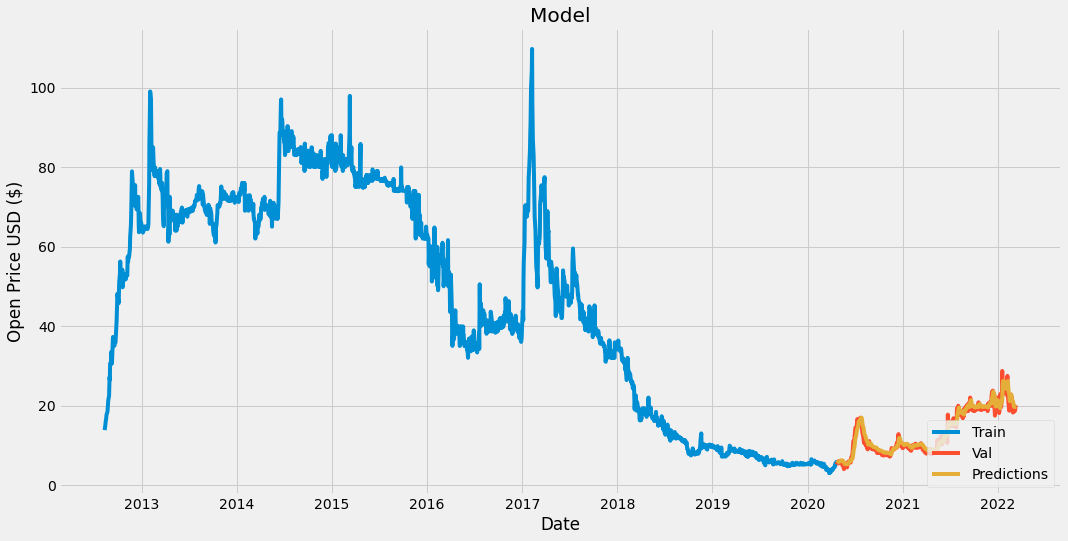

In [40]:
#plot the date
train = data[:training_data_len]
valid = data[training_data_len:]
valid['Predictions'] = predictions
#visualize the data
plt.figure(figsize=(16,8))
plt.title('Model')
plt.xlabel('Date')
plt.ylabel('Open Price USD ($)')
plt.plot(train['Open'])
plt.plot(valid[['Open', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()

In [41]:
#show the valid and predicted prices
valid

,Open,Predictions
Date,,
2020-04-23,5.200000,5.590191
2020-04-24,5.500000,5.666247
2020-04-27,5.500000,5.696487
2020-04-28,5.400000,5.718592
2020-04-29,5.990000,5.737366
...,...,...
2022-03-07,19.400000,19.725588
2022-03-08,18.650000,19.846909
2022-03-09,19.049999,19.793499


In [42]:
#get the Quote
stock_quote = web.DataReader(STOCK, data_source = 'yahoo', start=START_DATE, end=END_DATE)
#create new data frame
new_df = stock_quote.filter(['Open'])
#get the last 60 days closing price values and convert the dataframe to an array
last_60_days = new_df[-60:].values
#scale the data to be values between 0 and 1
last_60_days_scaled = scaler.fit_transform(last_60_days)
#create the empty list
x_test = []
#append the past 60 days
x_test.append(last_60_days_scaled)
#convert the x_test data set to a numpy array
x_test = np.array(x_test)
x_test = np.reshape(x_test,(x_test.shape[0],x_test.shape[1],1))
#get the predicted scaled price
pred_open_price = open_model.predict(x_test)
#undo the scaling
pred_open_price = scaler.inverse_transform(pred_open_price)
print(pred_open_price)


[[19.457357]]


In [43]:
stock_quote2 = web.DataReader(STOCK, data_source = 'yahoo', start=START_DATE, end=PREDICT_DATE)
print(stock_quote2['Open'])

Date
2012-08-10    13.812500
2012-08-13    15.225000
2012-08-14    15.975000
2012-08-16    16.762501
2012-08-17    17.600000
                ...    
2022-03-07    19.400000
2022-03-08    18.650000
2022-03-09    19.049999
2022-03-10    19.600000
2022-03-11    20.049999
Name: Open, Length: 2360, dtype: float64


In [44]:
open_model.save(open_model_path)
loaded_open_model = load_model(open_model_path)


In [45]:
import winsound
frequency = 2500  # Set Frequency To 2500 Hertz
duration = 1000  # Set Duration To 1000 ms == 1 second
winsound.Beep(frequency, duration)

In [46]:
print("Open price : ", end="") 
print(pred_open_price[0][0])
print("Close price : ", end="") 
print(close_pred_price[0][0])

print(close_pred_price[0][0]-pred_open_price[0][0]   )

Open price : 19.457357
Close price : 19.511204
0.05384636


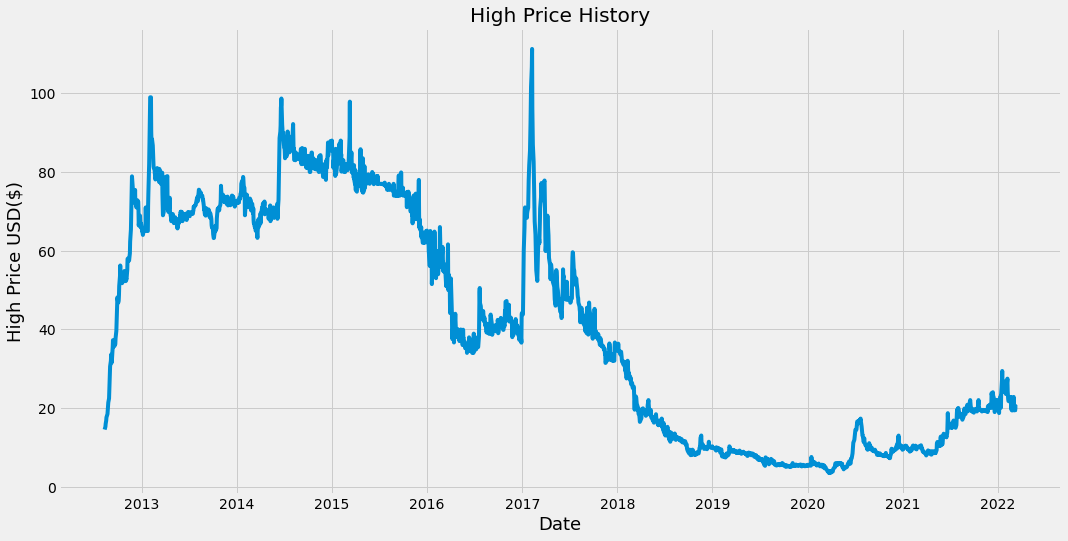

In [47]:
#Visualing the High price history
plt.figure(figsize=(16,8))
plt.title('High Price History')
plt.plot(df['High'])
plt.xlabel('Date', fontsize=18)
plt.ylabel('High Price USD($)', fontsize=18)
plt.show()

In [48]:
#Create a new data
data = df.filter(['High'])
#convert the dataframe to a numpy array
dataset = data.values
#get the number of rows to train the model on
training_data_len = math.ceil(len(dataset)*.8)
training_data_len

1888

In [49]:
#Scale the data
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(dataset)

scaled_data

array([[0.10262352],
       [0.10934458],
       [0.11629739],
       ...,
       [0.1485121 ],
       [0.15824603],
       [0.15685547]])

In [50]:
#creating the training data set
#create the scaled training data set
train_data = scaled_data[0:training_data_len,:]
#split the data into x_train and y_train data sets
x_train = []
y_train = []
for i in range(60, len(train_data)):
    x_train.append(train_data[i-60:i,0])
    y_train.append(train_data[i,0])
    if i<=61:
        print(x_train)
        print(y_train)
        print()

[array([0.10262352, 0.10934458, 0.11629739, 0.12359785, 0.13136182,
       0.13947344, 0.1479327 , 0.15685547, 0.16624176, 0.17609158,
       0.19683415, 0.21966255, 0.23797163, 0.25141372, 0.26462408,
       0.27934086, 0.26508761, 0.26022063, 0.26659404, 0.29707052,
       0.31340964, 0.2973023 , 0.29741819, 0.2984611 , 0.29973579,
       0.30402334, 0.3037916 , 0.31792897, 0.335311  , 0.35362009,
       0.37285622, 0.39301937, 0.41422544, 0.4015945 , 0.40622971,
       0.41851302, 0.44099378, 0.46463333, 0.4894317 , 0.44794659,
       0.4554788 , 0.45721701, 0.45246591, 0.44771481, 0.47042735,
       0.46706683, 0.4548994 , 0.45188651, 0.46405393, 0.47645313,
       0.46162044, 0.4525818 , 0.45953461, 0.45744878, 0.4560582 ,
       0.47923425, 0.5047279 , 0.5058867 , 0.50577081, 0.49951329])]
[0.50125149195334]

[array([0.10262352, 0.10934458, 0.11629739, 0.12359785, 0.13136182,
       0.13947344, 0.1479327 , 0.15685547, 0.16624176, 0.17609158,
       0.19683415, 0.21966255, 0.23797

In [51]:
#Convert the X_train and Y_train to numpy arrays
x_train , y_train = np.array(x_train), np.array(y_train)

In [52]:
#Reshape the data
x_train = np.reshape(x_train,(x_train.shape[0],x_train.shape[1],1))
x_train.shape

(1828, 60, 1)

In [53]:
#Building the LSTM model
high_model = Sequential()
high_model.add(LSTM(50, return_sequences=True, input_shape =(x_train.shape[1],1)))
high_model.add(LSTM(50, return_sequences=True))
high_model.add(LSTM(50, return_sequences=True))
high_model.add(LSTM(50, return_sequences=False))
high_model.add(Dense(25))
high_model.add(Dense(1))

In [54]:
#compile the Model
high_model.compile(optimizer='adam', loss='mean_squared_error')


In [55]:
#train the model
high_model.fit(x_train, y_train, batch_size=32, epochs=EPOCHS)

Epoch 1/100
58/58 [==============================] - 16s 154ms/step - loss: 0.0188
Epoch 2/100
58/58 [==============================] - 9s 153ms/step - loss: 0.0030
Epoch 3/100
58/58 [==============================] - 9s 158ms/step - loss: 0.0029
Epoch 4/100
58/58 [==============================] - 9s 152ms/step - loss: 0.0026
Epoch 5/100
58/58 [==============================] - 9s 152ms/step - loss: 0.0027
Epoch 6/100
58/58 [==============================] - 9s 150ms/step - loss: 0.0023
Epoch 7/100
58/58 [==============================] - 9s 155ms/step - loss: 0.0019
Epoch 8/100
58/58 [==============================] - 9s 152ms/step - loss: 0.0021
Epoch 9/100
58/58 [==============================] - 9s 152ms/step - loss: 0.0014
Epoch 10/100
58/58 [==============================] - 9s 152ms/step - loss: 0.0015
Epoch 11/100
58/58 [==============================] - 9s 152ms/step - loss: 0.0011
Epoch 12/100
58/58 [==============================] - 9s 151ms/step - loss: 0.0010
Epoch 13/100

58/58 [==============================] - 9s 153ms/step - loss: 3.8823e-04
Epoch 96/100
58/58 [==============================] - 9s 152ms/step - loss: 3.5910e-04
Epoch 97/100
58/58 [==============================] - 9s 154ms/step - loss: 4.3946e-04
Epoch 98/100
58/58 [==============================] - 9s 153ms/step - loss: 4.5871e-04
Epoch 99/100
58/58 [==============================] - 9s 152ms/step - loss: 4.7629e-04
Epoch 100/100
58/58 [==============================] - 9s 155ms/step - loss: 4.1413e-04


In [56]:
#create the testing data set
#create a new array containing scaled values from index 1543 to 2003
test_data = scaled_data[training_data_len - 60: , :]
#create the data sets x_test adn y_test
x_test = []
y_test = dataset[training_data_len:,:]
for i in range(60, len(test_data)):
    x_test.append(test_data[i-60:i,0])
    
    


In [57]:
#convert the data to a numpy array
x_test = np.array(x_test)

In [58]:
#resahpe the data
x_test = np.reshape(x_test,(x_test.shape[0],x_test.shape[1],1))

In [59]:
#get the models predicted price values
predictions = high_model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

In [60]:
#get the root mean squared error (RMSE)
rmse =  np.sqrt(np.mean(predictions - y_test)**2)
rmse

0.2995097051232548

C:\Users\Abhishek Rao\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.7_qbz5n2kfra8p0\LocalCache\local-packages\Python37\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


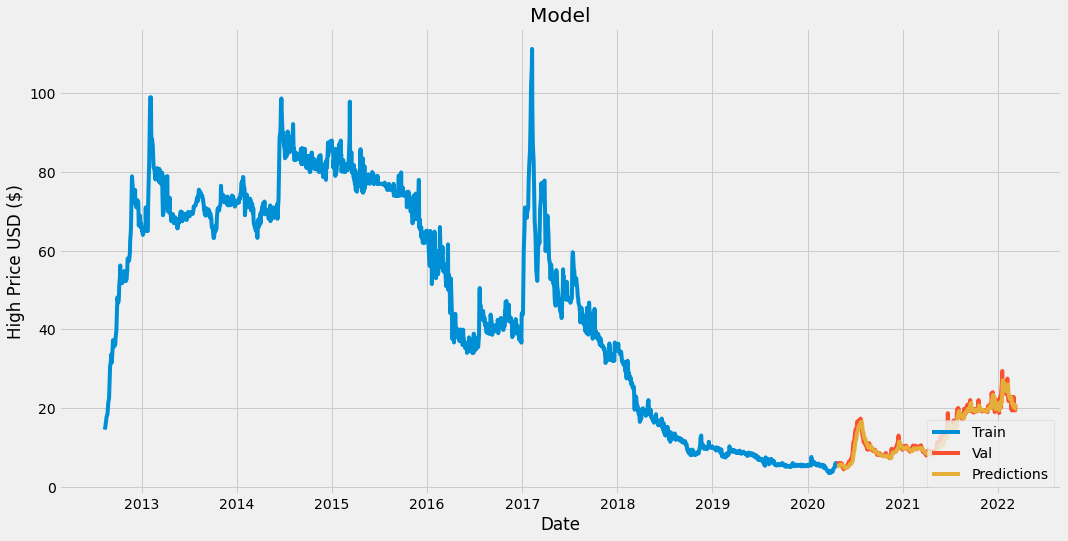

In [61]:
#plot the date
train = data[:training_data_len]
valid = data[training_data_len:]
valid['Predictions'] = predictions
#visualize the data
plt.figure(figsize=(16,8))
plt.title('Model')
plt.xlabel('Date')
plt.ylabel('High Price USD ($)')
plt.plot(train['High'])
plt.plot(valid[['High', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()

In [62]:
#show the valid and predicted prices
valid

,High,Predictions
Date,,
2020-04-23,5.500000,5.245088
2020-04-24,5.500000,5.247082
2020-04-27,5.700000,5.214320
2020-04-28,5.850000,5.201865
2020-04-29,5.990000,5.235543
...,...,...
2022-03-07,19.400000,20.842379
2022-03-08,19.500000,20.475056
2022-03-09,19.450001,20.072060


In [63]:
#get the Quote
stock_quote = web.DataReader(STOCK, data_source = 'yahoo', start=START_DATE, end=END_DATE)
#create new data frame
new_df = stock_quote.filter(['High'])
#get the last 60 days closing price values and convert the dataframe to an array
last_60_days = new_df[-60:].values
#scale the data to be values between 0 and 1
last_60_days_scaled = scaler.fit_transform(last_60_days)
#create the empty list
x_test = []
#append the past 60 days
x_test.append(last_60_days_scaled)
#convert the x_test data set to a numpy array
x_test = np.array(x_test)
x_test = np.reshape(x_test,(x_test.shape[0],x_test.shape[1],1))
#get the predicted scaled price
high_pred_price = high_model.predict(x_test)
#undo the scaling
high_pred_price = scaler.inverse_transform(high_pred_price)
print(high_pred_price)


[[19.985027]]


In [64]:
stock_quote2 = web.DataReader(STOCK, data_source = 'yahoo', start=START_DATE, end=PREDICT_DATE)
print(stock_quote2['High'])

Date
2012-08-10    14.500000
2012-08-13    15.225000
2012-08-14    15.975000
2012-08-16    16.762501
2012-08-17    17.600000
                ...    
2022-03-07    19.400000
2022-03-08    19.500000
2022-03-09    19.450001
2022-03-10    20.500000
2022-03-11    20.350000
Name: High, Length: 2360, dtype: float64


In [65]:
high_model.save(high_model_path)
loaded_high_model = load_model(high_model_path)


In [66]:
stock_quote2 = web.DataReader(STOCK, data_source = 'yahoo', start=START_DATE, end=PREDICT_DATE)
print(stock_quote2['High'])

Date
2012-08-10    14.500000
2012-08-13    15.225000
2012-08-14    15.975000
2012-08-16    16.762501
2012-08-17    17.600000
                ...    
2022-03-07    19.400000
2022-03-08    19.500000
2022-03-09    19.450001
2022-03-10    20.500000
2022-03-11    20.350000
Name: High, Length: 2360, dtype: float64


In [67]:
import winsound
frequency = 2500  # Set Frequency To 2500 Hertz
duration = 1000  # Set Duration To 1000 ms == 1 second
winsound.Beep(frequency, duration)

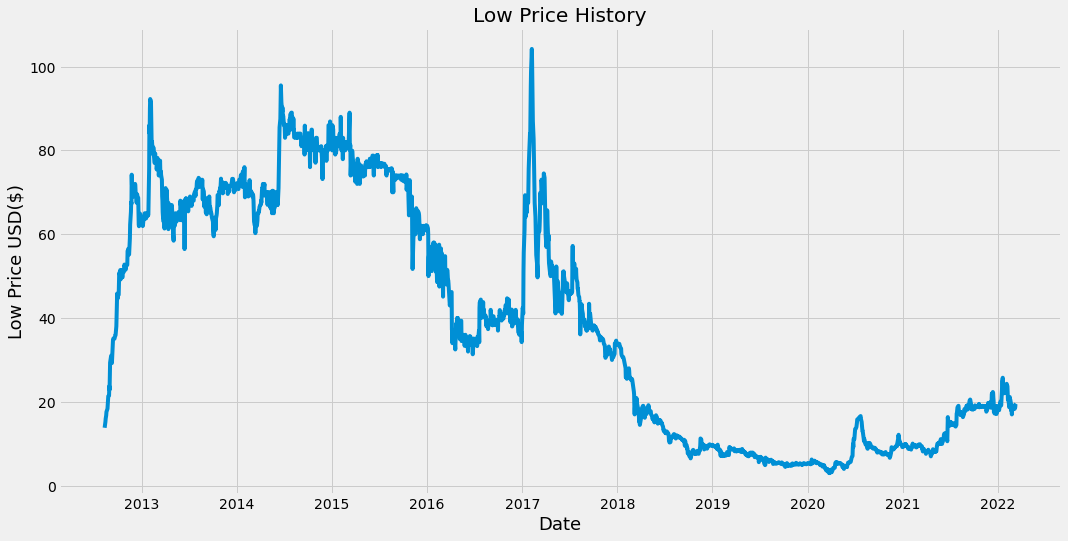

In [68]:
#Visualing the low price history
plt.figure(figsize=(16,8))
plt.title('Low Price History')
plt.plot(df['Low'])
plt.xlabel('Date', fontsize=18)
plt.ylabel('Low Price USD($)', fontsize=18)
plt.show()

In [69]:
#Create a new data
data = df.filter(['Low'])
#convert the dataframe to a numpy array
dataset = data.values
#get the number of rows to train the model on
training_data_len = math.ceil(len(dataset)*.8)
training_data_len

1888

In [70]:
#Scale the data
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(dataset)

scaled_data

array([[0.10684289],
       [0.1208004 ],
       [0.12821147],
       ...,
       [0.15513835],
       [0.16304348],
       [0.16403163]])

In [71]:
#creating the training data set
#create the scaled training data set
train_data = scaled_data[0:training_data_len,:]
#split the data into x_train and y_train data sets
x_train = []
y_train = []
for i in range(60, len(train_data)):
    x_train.append(train_data[i-60:i,0])
    y_train.append(train_data[i,0])
    if i<=61:
        print(x_train)
        print(y_train)
        print()

[array([0.10684289, 0.1208004 , 0.12821147, 0.13599309, 0.14426878,
       0.15192688, 0.16193183, 0.1714427 , 0.18144763, 0.18292985,
       0.20503953, 0.19664032, 0.23221345, 0.26049901, 0.27173914,
       0.27667985, 0.27161561, 0.26926878, 0.25951088, 0.30385376,
       0.31274706, 0.31632907, 0.31756425, 0.31645259, 0.31682313,
       0.32028162, 0.32485179, 0.32497531, 0.34609686, 0.36684784,
       0.39525693, 0.42317196, 0.41020259, 0.41958995, 0.42045455,
       0.45034587, 0.47183796, 0.46689725, 0.47863144, 0.45639824,
       0.46566207, 0.4693676 , 0.47838439, 0.46195654, 0.46257412,
       0.46195654, 0.47406126, 0.47554349, 0.47430831, 0.49160081,
       0.47924903, 0.48023715, 0.48666009, 0.4888834 , 0.48913045,
       0.49098322, 0.51852767, 0.52519766, 0.51679843, 0.52877967])]
[0.5153162361511784]

[array([0.10684289, 0.1208004 , 0.12821147, 0.13599309, 0.14426878,
       0.15192688, 0.16193183, 0.1714427 , 0.18144763, 0.18292985,
       0.20503953, 0.19664032, 0.232

In [72]:
#Convert the X_train and Y_train to numpy arrays
x_train , y_train = np.array(x_train), np.array(y_train)

In [73]:
#Reshape the data
x_train = np.reshape(x_train,(x_train.shape[0],x_train.shape[1],1))
x_train.shape

(1828, 60, 1)

In [74]:
#Building the LSTM model
low_model = Sequential()
low_model.add(LSTM(50, return_sequences=True, input_shape =(x_train.shape[1],1)))
low_model.add(LSTM(50, return_sequences=True))
low_model.add(LSTM(50, return_sequences=True))
low_model.add(LSTM(50, return_sequences=False))
low_model.add(Dense(25))
low_model.add(Dense(1))

In [75]:
#compile the Model
low_model.compile(optimizer='adam', loss='mean_squared_error')

In [76]:
#train the model
low_model.fit(x_train, y_train, batch_size=32, epochs=EPOCHS)

Epoch 1/100
58/58 [==============================] - 17s 152ms/step - loss: 0.0186
Epoch 2/100
58/58 [==============================] - 9s 153ms/step - loss: 0.0033
Epoch 3/100
58/58 [==============================] - 9s 152ms/step - loss: 0.0031
Epoch 4/100
58/58 [==============================] - 9s 151ms/step - loss: 0.0027
Epoch 5/100
58/58 [==============================] - 9s 151ms/step - loss: 0.0027
Epoch 6/100
58/58 [==============================] - 9s 151ms/step - loss: 0.0027
Epoch 7/100
58/58 [==============================] - 9s 151ms/step - loss: 0.0021
Epoch 8/100
58/58 [==============================] - 9s 154ms/step - loss: 0.0018
Epoch 9/100
58/58 [==============================] - 9s 151ms/step - loss: 0.0015
Epoch 10/100
58/58 [==============================] - 9s 161ms/step - loss: 0.0014
Epoch 11/100
58/58 [==============================] - 9s 151ms/step - loss: 0.0012
Epoch 12/100
58/58 [==============================] - 9s 160ms/step - loss: 0.0016
Epoch 13/100

Epoch 96/100
58/58 [==============================] - 9s 153ms/step - loss: 3.7987e-04
Epoch 97/100
58/58 [==============================] - 9s 152ms/step - loss: 3.8805e-04
Epoch 98/100
58/58 [==============================] - 9s 152ms/step - loss: 4.5255e-04
Epoch 99/100
58/58 [==============================] - 9s 153ms/step - loss: 4.2070e-04
Epoch 100/100
58/58 [==============================] - 9s 152ms/step - loss: 4.2967e-04


In [77]:
#create the testing data set
#create a new array containing scaled values from index 1543 to 2003
test_data = scaled_data[training_data_len - 60: , :]
#create the data sets x_test adn y_test
x_test = []
y_test = dataset[training_data_len:,:]
for i in range(60, len(test_data)):
    x_test.append(test_data[i-60:i,0])
    
    


In [78]:
#convert the data to a numpy array
x_test = np.array(x_test)

In [79]:
#resahpe the data
x_test = np.reshape(x_test,(x_test.shape[0],x_test.shape[1],1))

In [80]:
#get the models predicted price values
predictions = open_model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

In [81]:
#get the root mean squared error (RMSE)
rmse =  np.sqrt(np.mean(predictions - y_test)**2)
rmse

0.2608788255917824

C:\Users\Abhishek Rao\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.7_qbz5n2kfra8p0\LocalCache\local-packages\Python37\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


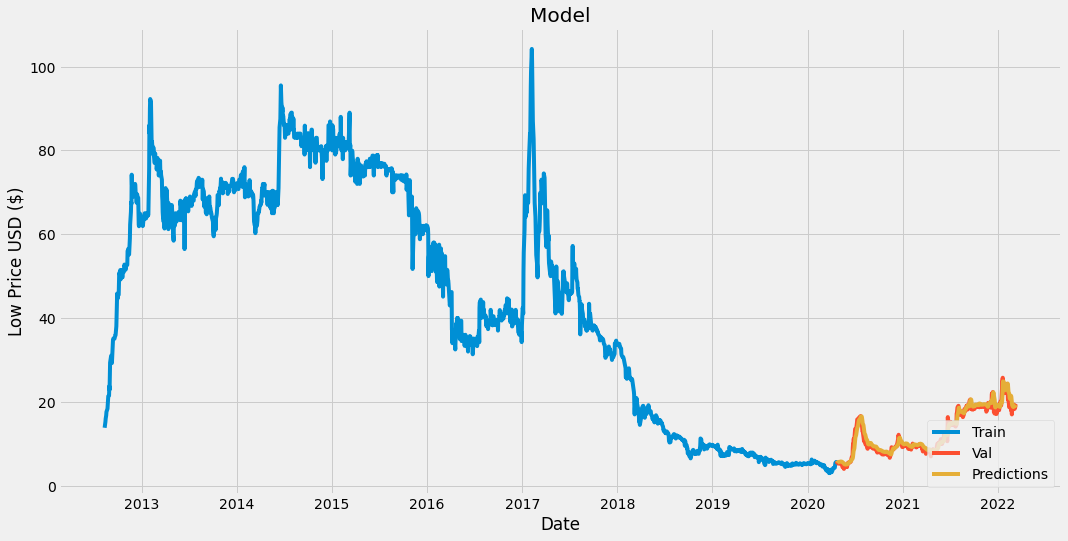

In [82]:
#plot the date
train = data[:training_data_len]
valid = data[training_data_len:]
valid['Predictions'] = predictions
#visualize the data
plt.figure(figsize=(16,8))
plt.title('Model')
plt.xlabel('Date')
plt.ylabel('Low Price USD ($)')
plt.plot(train['Low'])
plt.plot(valid[['Low', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()

In [83]:
#show the valid and predicted prices
valid

,Low,Predictions
Date,,
2020-04-23,5.200000,5.425401
2020-04-24,5.500000,5.515337
2020-04-27,5.500000,5.569737
2020-04-28,5.250000,5.617374
2020-04-29,5.400000,5.644252
...,...,...
2022-03-07,18.350000,19.153685
2022-03-08,18.650000,19.118549
2022-03-09,18.700001,19.075573


In [84]:
#get the Quote
stock_quote = web.DataReader(STOCK, data_source = 'yahoo', start=START_DATE, end=END_DATE)
#create new data frame
new_df = stock_quote.filter(['Low'])
#get the last 60 days closing price values and convert the dataframe to an array
last_60_days = new_df[-60:].values
#scale the data to be values between 0 and 1
last_60_days_scaled = scaler.fit_transform(last_60_days)
#create the empty list
x_test = []
#append the past 60 days
x_test.append(last_60_days_scaled)
#convert the x_test data set to a numpy array
x_test = np.array(x_test)
x_test = np.reshape(x_test,(x_test.shape[0],x_test.shape[1],1))
#get the predicted scaled price
low_pred_price = low_model.predict(x_test)
#undo the scaling
low_pred_price = scaler.inverse_transform(low_pred_price)
print(low_pred_price)


[[19.22954]]


In [85]:
stock_quote2 = web.DataReader(STOCK, data_source = 'yahoo', start=START_DATE, end=PREDICT_DATE)
print(stock_quote2['Low'])

Date
2012-08-10    13.812500
2012-08-13    15.225000
2012-08-14    15.975000
2012-08-16    16.762501
2012-08-17    17.600000
                ...    
2022-03-07    18.350000
2022-03-08    18.650000
2022-03-09    18.700001
2022-03-10    19.500000
2022-03-11    19.600000
Name: Low, Length: 2360, dtype: float64


In [86]:
low_model.save(low_model_path)
loaded_low_model = load_model(low_model_path)


In [87]:
import winsound
frequency = 2500  # Set Frequency To 2500 Hertz
duration = 1000  # Set Duration To 1000 ms == 1 second
winsound.Beep(frequency, duration)

In [88]:
print("Open price : ", end="") 
print(pred_open_price[0][0])
print("Close price : ", end="") 
print(close_pred_price[0][0])
print("High price : ", end="") 
print(high_pred_price[0][0])
print("Low price : ", end="") 
print(low_pred_price[0][0])

print("Open to Close: ", end="")
print(close_pred_price[0][0]-pred_open_price[0][0]   )

Open price : 19.457357
Close price : 19.511204
High price : 19.985027
Low price : 19.22954
Open to Close: 0.05384636


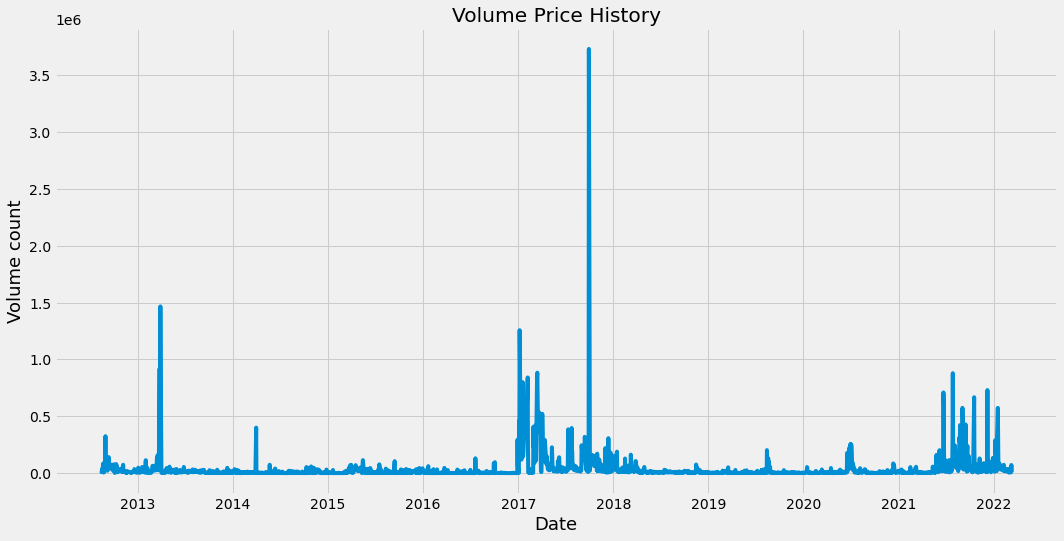

In [89]:
#Visualing the Volume history
plt.figure(figsize=(16,8))
plt.title('Volume Price History')
plt.plot(df['Volume'])
plt.xlabel('Date', fontsize=18)
plt.ylabel('Volume count', fontsize=18)
plt.show()

In [90]:
#Create a new data
data = df.filter(['Volume'])
#convert the dataframe to a numpy array
dataset = data.values
#get the number of rows to train the model on
training_data_len = math.ceil(len(dataset)*.8)
training_data_len

1888

In [91]:
#Scale the data
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(dataset)

scaled_data

array([[0.00468522],
       [0.00459518],
       [0.00216735],
       ...,
       [0.00271214],
       [0.01908575],
       [0.0019101 ]])

In [92]:
#creating the training data set
#create the scaled training data set
train_data = scaled_data[0:training_data_len,:]
#split the data into x_train and y_train data sets
x_train = []
y_train = []
for i in range(60, len(train_data)):
    x_train.append(train_data[i-60:i,0])
    y_train.append(train_data[i,0])
    if i<=61:
        print(x_train)
        print(y_train)
        print()

[array([0.00468522, 0.00459518, 0.00216735, 0.00840038, 0.00790195,
       0.02305521, 0.00125947, 0.00162498, 0.00195726, 0.02548196,
       0.02057594, 0.08699325, 0.01509752, 0.01349827, 0.00696833,
       0.03783009, 0.01080462, 0.00563169, 0.00833713, 0.01356687,
       0.03732952, 0.02196832, 0.01236636, 0.0205695 , 0.01611689,
       0.01920285, 0.01015184, 0.01006716, 0.01980846, 0.00954729,
       0.00840681, 0.00576246, 0.01703978, 0.02046339, 0.0192468 ,
       0.00034944, 0.00738959, 0.00938865, 0.02134448, 0.00850113,
       0.0174396 , 0.00704337, 0.00199157, 0.00507002, 0.00377197,
       0.0086169 , 0.00425432, 0.00836822, 0.00448049, 0.00556845,
       0.0107671 , 0.00336572, 0.00634878, 0.00320173, 0.00352651,
       0.01958015, 0.00598541, 0.00604973, 0.00288766, 0.00283728])]
[0.004262893054121163]

[array([0.00468522, 0.00459518, 0.00216735, 0.00840038, 0.00790195,
       0.02305521, 0.00125947, 0.00162498, 0.00195726, 0.02548196,
       0.02057594, 0.08699325, 0.0

In [93]:
#Convert the X_train and Y_train to numpy arrays
x_train , y_train = np.array(x_train), np.array(y_train)

In [94]:
#Reshape the data
x_train = np.reshape(x_train,(x_train.shape[0],x_train.shape[1],1))
x_train.shape

(1828, 60, 1)

In [95]:
#Building the LSTM model
volume_model = Sequential()
volume_model.add(LSTM(50, return_sequences=True, input_shape =(x_train.shape[1],1)))
volume_model.add(LSTM(50, return_sequences=True))
volume_model.add(LSTM(50, return_sequences=True))
volume_model.add(LSTM(50, return_sequences=False))
volume_model.add(Dense(25))
volume_model.add(Dense(1))

In [96]:
#compile the Model
volume_model.compile(optimizer='adam', loss='mean_squared_error')


In [97]:
#train the model
volume_model.fit(x_train, y_train, batch_size=32, epochs=EPOCHS)

Epoch 1/100
58/58 [==============================] - 14s 148ms/step - loss: 0.0011
Epoch 2/100
58/58 [==============================] - 9s 153ms/step - loss: 0.0011
Epoch 3/100
58/58 [==============================] - 9s 153ms/step - loss: 0.0010
Epoch 4/100
58/58 [==============================] - 9s 160ms/step - loss: 0.0010
Epoch 5/100
58/58 [==============================] - 9s 161ms/step - loss: 0.0010
Epoch 6/100
58/58 [==============================] - 9s 154ms/step - loss: 0.0010
Epoch 7/100
58/58 [==============================] - 9s 154ms/step - loss: 9.9251e-04
Epoch 8/100
58/58 [==============================] - 9s 155ms/step - loss: 0.0010
Epoch 9/100
58/58 [==============================] - 9s 154ms/step - loss: 9.9912e-04
Epoch 10/100
58/58 [==============================] - 9s 154ms/step - loss: 9.9949e-04
Epoch 11/100
58/58 [==============================] - 9s 157ms/step - loss: 9.9389e-04
Epoch 12/100
58/58 [==============================] - 9s 154ms/step - loss: 9.7

58/58 [==============================] - 9s 155ms/step - loss: 8.3054e-04
Epoch 96/100
58/58 [==============================] - 9s 153ms/step - loss: 8.4692e-04
Epoch 97/100
58/58 [==============================] - 9s 153ms/step - loss: 8.2951e-04
Epoch 98/100
58/58 [==============================] - 9s 155ms/step - loss: 8.2591e-04
Epoch 99/100
58/58 [==============================] - 9s 154ms/step - loss: 8.1646e-04
Epoch 100/100
58/58 [==============================] - 9s 154ms/step - loss: 8.1920e-04


In [98]:
#create the testing data set
#create a new array containing scaled values from index 1543 to 2003
test_data = scaled_data[training_data_len - 60: , :]
#create the data sets x_test adn y_test
x_test = []
y_test = dataset[training_data_len:,:]
for i in range(60, len(test_data)):
    x_test.append(test_data[i-60:i,0])
    
    


In [99]:
#convert the data to a numpy array
x_test = np.array(x_test)

In [100]:
#resahpe the data
x_test = np.reshape(x_test,(x_test.shape[0],x_test.shape[1],1))

In [101]:
#get the models predicted price values
predictions = volume_model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

In [102]:
#get the root mean squared error (RMSE)
rmse =  np.sqrt(np.mean(predictions - y_test)**2)
rmse

3510.393957032996

C:\Users\Abhishek Rao\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.7_qbz5n2kfra8p0\LocalCache\local-packages\Python37\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


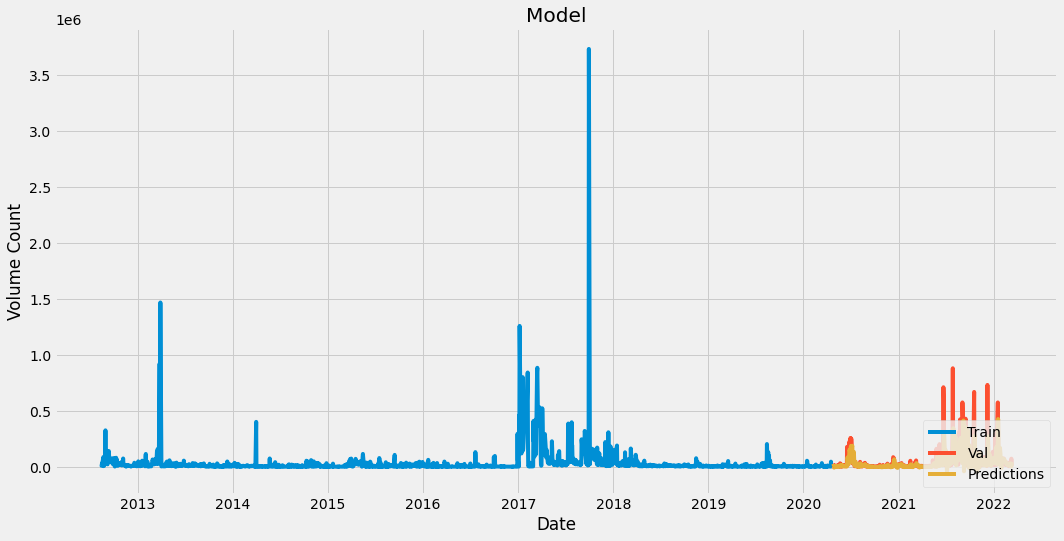

In [103]:
#plot the date
train = data[:training_data_len]
valid = data[training_data_len:]
valid['Predictions'] = predictions
#visualize the data
plt.figure(figsize=(16,8))
plt.title('Model')
plt.xlabel('Date')
plt.ylabel('Volume Count')
plt.plot(train['Volume'])
plt.plot(valid[['Volume', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()

In [104]:
#show the valid and predicted prices
valid

,Volume,Predictions
Date,,
2020-04-23,361.0,3858.064453
2020-04-24,0.0,6770.086426
2020-04-27,110.0,-851.214600
2020-04-28,10301.0,-8602.824219
2020-04-29,3941.0,-3601.867920
...,...,...
2022-03-07,11649.0,29676.515625
2022-03-08,5650.0,18702.605469
2022-03-09,10121.0,1576.899414


In [105]:
#get the Quote
stock_quote = web.DataReader(STOCK, data_source = 'yahoo', start=START_DATE, end=END_DATE)
#create new data frame
new_df = stock_quote.filter(['Volume'])
#get the last 60 days closing price values and convert the dataframe to an array
last_60_days = new_df[-60:].values
#scale the data to be values between 0 and 1
last_60_days_scaled = scaler.fit_transform(last_60_days)
#create the empty list
x_test = []
#append the past 60 days
x_test.append(last_60_days_scaled)
#convert the x_test data set to a numpy array
x_test = np.array(x_test)
x_test = np.reshape(x_test,(x_test.shape[0],x_test.shape[1],1))
#get the predicted scaled price
volume_pred_price = volume_model.predict(x_test)
#undo the scaling
volume_pred_price = scaler.inverse_transform(volume_pred_price)
print(volume_pred_price)


[[43647.89]]


In [106]:
stock_quote2 = web.DataReader(STOCK, data_source = 'yahoo', start=START_DATE, end=PREDICT_DATE)
print(stock_quote2['Volume'])

Date
2012-08-10    17484.0
2012-08-13    17148.0
2012-08-14     8088.0
2012-08-16    31348.0
2012-08-17    29488.0
               ...   
2022-03-07    11649.0
2022-03-08     5650.0
2022-03-09    10121.0
2022-03-10    71223.0
2022-03-11     7128.0
Name: Volume, Length: 2360, dtype: float64


In [107]:
volume_model.save(volume_model_path)
loaded_volume_model = load_model(volume_model_path)


In [108]:
stock_quote2 = web.DataReader(STOCK, data_source = 'yahoo', start=START_DATE, end=PREDICT_DATE)
print(stock_quote2['Volume'])

Date
2012-08-10    17484.0
2012-08-13    17148.0
2012-08-14     8088.0
2012-08-16    31348.0
2012-08-17    29488.0
               ...   
2022-03-07    11649.0
2022-03-08     5650.0
2022-03-09    10121.0
2022-03-10    71223.0
2022-03-11     7128.0
Name: Volume, Length: 2360, dtype: float64


In [109]:
import winsound
frequency = 2500  # Set Frequency To 2500 Hertz
duration = 1000  # Set Duration To 1000 ms == 1 second
winsound.Beep(frequency, duration)

In [110]:
exe_time = time.time() - start_time
print("Time taken is :", end="")
print(exe_time/60)

Time taken is :75.98862271308899
